In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import cross_val_score

from tradPointOut import rankToPoints2017
from tabulabuilder import School

sns.set_style("whitegrid")

In [18]:
rawDf = pd.read_csv("data/tier7QLonly.csv")
df = rawDf.copy()
df.isRelay = df.isRelay.astype(int)

In [19]:
df2018 = df.loc[df["year"] == 2018]
testSet = df2018.sample(frac = 0.6, random_state = 33)
testY = testSet.pop("points")
testX = testSet.copy()

trainSet = df[~df.index.isin(testSet.index)]
trainY = trainSet.pop("points")
trainX = trainSet.copy()

xCols = ["divsSpeed", "isRelay", "divsTimePctOfMean",  "clipped_divsRank"]

y2018 = df2018["points"]
x2018 = df2018[xCols]

trainX = trainX[xCols] 
testX = testX[xCols] 

In [22]:
df2018["tradPred"] = df.apply(lambda row: rankToPoints2017(row["divsRank"]), axis=1)
df2018["tradError"] = df2018["points"] - df2018["tradPred"]

c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, criterion="friedman_mse", min_samples_leaf=64, learning_rate=0.1)
gbr = gbr.fit(trainX, trainY)
scores = cross_val_score(gbr, trainX, trainY, cv=4)
print(f"R^2: {scores.mean()} (+/- {scores.std() * 2})")

gbrY = gbr.predict(x2018)
gbrErrors = y2018 - gbrY
print("MAE:", gbrErrors.abs().mean())
df2018["gbrPred"] = gbrY
df2018["gbrError"] = gbrErrors

pd.DataFrame([xCols, gbr.feature_importances_])

R^2: 0.7243516790323855 (+/- 0.19094755634241642)
MAE: 1.7127097892004486
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,0,1,2,3
0,divsSpeed,isRelay,divsTimePctOfMean,clipped_divsRank
1,0.0293499,0.00107426,0.0427699,0.926806


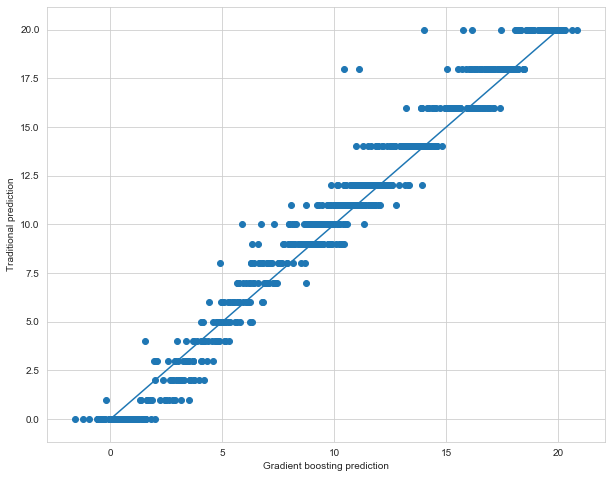

In [78]:
plt.figure(figsize = (10,8))
plt.xlabel("Gradient boosting prediction")
plt.ylabel("Traditional prediction")
lineX = np.linspace(0,20,20)
plt.plot(lineX, lineX)
plt.scatter(df2018["gbrPred"], df2018["tradPred"])